# Churn case

In this notebook, you will work on a Churn case that was originally posed as a challenge by Maven Analytics, see [here](https://www.mavenanalytics.io/blog/maven-churn-challenge).

The dataset can be downloaded [here](https://maven-datasets.s3.amazonaws.com/Telecom+Customer+Churn/Telecom+Customer+Churn.zip), or from Kaggle [here](https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics/data), and from moodle. The dataset contains 3 files:
* The *telecom_customer_churn.csv* file contains information on all 7,043 customers from a Telecommunications company in California in Q2 2022. Each record represents one customer, and contains details about their demographics, location, tenure, subscription services, status for the quarter (joined, stayed, or churned), and more!
* The *telecom_zipcode_population.csv* file contains complimentary information on the estimated populations for the California zip codes in the Customer Churn table
* The *telecom_data_dictionary.csv* file contains metadata about the other two files in the sense of a dictionary of the variables in the two other files

We will ignore the Zip code file for simplicity.

The goal according to the Maven Churn Challenge is to *"help the company improve retention by identifying high value customers and churn risks, and have been asked to present your findings to the CMO in the form of a single page report or dashboard."* [(Maven Churn Challenge, 2022)](https://www.mavenanalytics.io/blog/maven-churn-challenge).

In [100]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as shc
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score

### Task 1

Load in the churn dataset from the file "telecom_customer_churn.csv" and investigate what variables there are in the data. (You might want to look up the data dictionary file to understand what the different variables mean.)

In [4]:
df = pd.read_csv("../Notebooks and data-11/telecom_customer_churn.csv")
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [6]:
df.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,1.951867,32.386767,25.420517,26.189958,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,1856.767505,2.468929,2.154425,3.001199,24.542061,14.200374,19.586585,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,13.050000,13.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,25.690000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,37.680000,30.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


### Task 2

Reflect on the business question and to what extent the data can help us answer the business question.

    Churn reason, churn category, 
    total revenue, customer status(age, gender, relationship), location(city, latitude, longitude), number of referals, tenure in months

### Task 3

Decide on a way to measure how valuable a customer is. Do some exploratory data analysis of the relevant variables.

In [59]:
df_valuable_customer = df[["Tenure in Months", "Age", "Total Revenue", "Number of Referrals", "Customer Status", "Churn Category", "Churn Reason"]]
df_valuable_customer

,Tenure in Months,Age,Total Revenue,Number of Referrals,Customer Status,Churn Category,Churn Reason
0,9,37,974.81,2,Stayed,NaN,NaN
1,9,46,610.28,0,Stayed,NaN,NaN
2,4,50,415.45,0,Churned,Competitor,Competitor had better devices
3,13,78,1599.51,1,Churned,Dissatisfaction,Product dissatisfaction
4,3,75,289.54,3,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...
7038,13,20,1349.74,0,Stayed,NaN,NaN
7039,22,40,2230.10,1,Churned,Dissatisfaction,Product dissatisfaction
7040,2,22,129.99,0,Joined,NaN,NaN
7041,67,21,4769.69,5,Stayed,NaN,NaN


In [48]:
df_valuable_customer.describe()

,Tenure in Months,Age,Total Revenue,Number of Referrals
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.386767,46.509726,3034.379056,1.951867
std,24.542061,16.750352,2865.204542,3.001199
min,1.000000,19.000000,21.360000,0.000000
25%,9.000000,32.000000,605.610000,0.000000
50%,29.000000,46.000000,2108.640000,0.000000
75%,55.000000,60.000000,4801.145000,3.000000
max,72.000000,80.000000,11979.340000,11.000000


In [33]:
df_valuable_customer.duplicated().sum()

0

In [34]:
df_valuable_customer.isna().sum()

Tenure in Months          0
Age                       0
City                      0
Total Revenue             0
Number of Referrals       0
Customer Status           0
Churn Category         5174
dtype: int64

In [38]:
df_valuable_customer[["Tenure in Months", "Total Revenue", "Age", "Number of Referrals"]].var()

Tenure in Months       6.023128e+02
Total Revenue          8.209397e+06
Age                    2.805743e+02
Number of Referrals    9.007197e+00
dtype: float64

<Axes: xlabel='Tenure in Months', ylabel='Number of Referrals'>

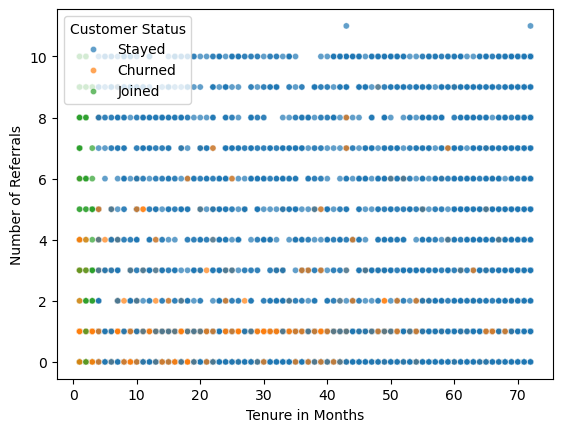

In [36]:
sns.scatterplot(data=df_valuable_customer, x="Tenure in Months", y="Number of Referrals", hue="Customer Status", alpha=0.7, s=20)

<Axes: xlabel='Total Revenue', ylabel='Number of Referrals'>

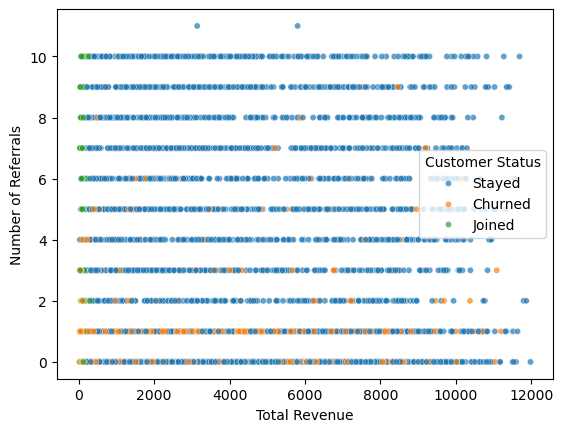

In [30]:
sns.scatterplot(data=df_valuable_customer, x="Total Revenue", y="Number of Referrals", hue="Customer Status", alpha=0.7, s=20)

<Axes: xlabel='Total Revenue', ylabel='Tenure in Months'>

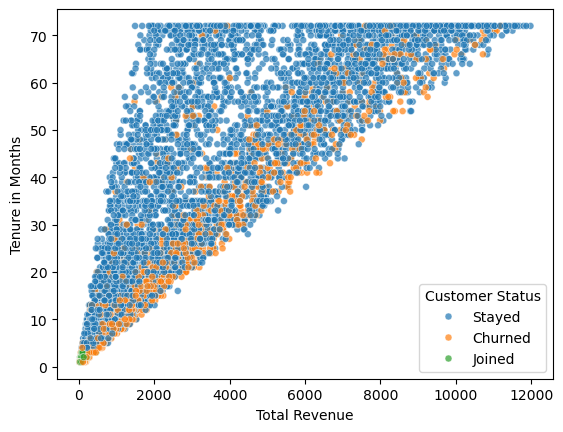

In [26]:
sns.scatterplot(data=df_valuable_customer, x="Total Revenue", y="Tenure in Months", hue="Customer Status", alpha=0.7, s=25)

<Axes: xlabel='Total Revenue', ylabel='Age'>

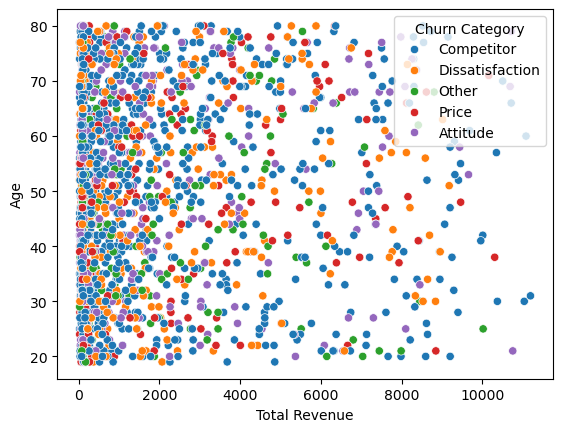

In [37]:
sns.scatterplot(data=df_valuable_customer, x="Total Revenue", y="Age", hue="Churn Category")

<Axes: xlabel='Total Revenue', ylabel='Tenure in Months'>

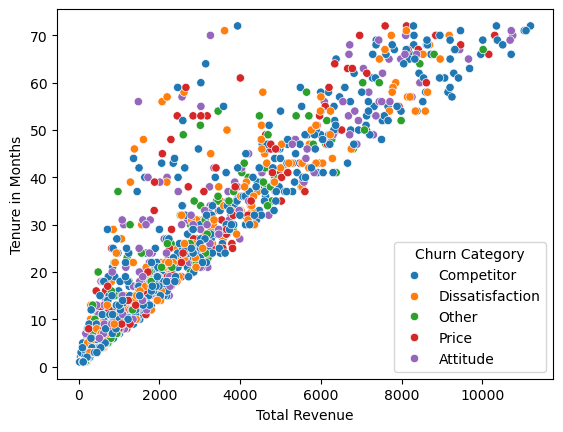

In [19]:
sns.scatterplot(data=df_valuable_customer, x="Total Revenue", y="Tenure in Months", hue="Churn Category")

<Axes: xlabel='Customer Status', ylabel='Total Revenue'>

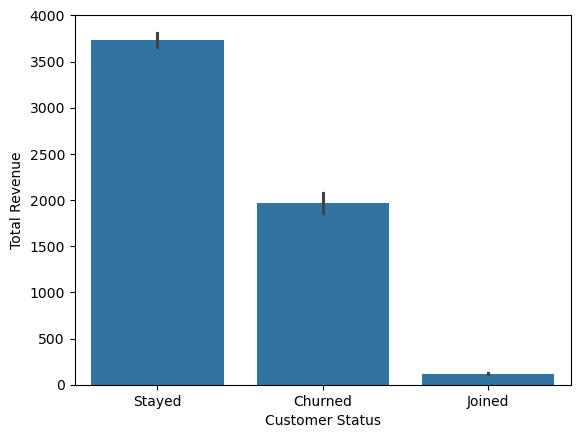

In [72]:
sns.barplot(df_valuable_customer, x="Customer Status", y="Total Revenue")

<Axes: xlabel='Customer Status', ylabel='count'>

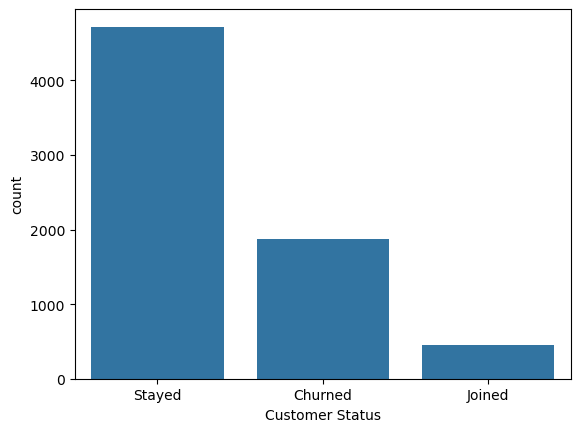

In [73]:
sns.countplot(df_valuable_customer, x="Customer Status")

<Axes: xlabel='Number of Referrals', ylabel='Count'>

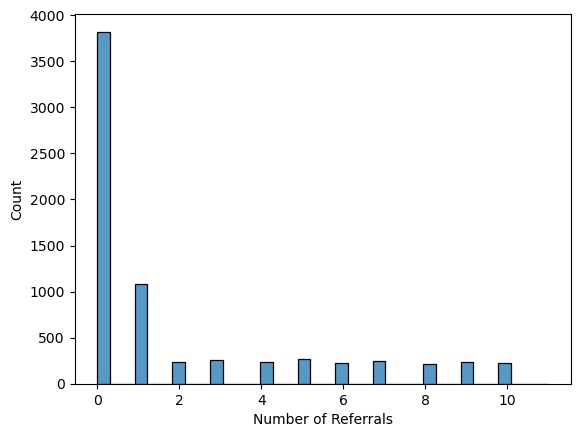

In [41]:
sns.histplot(x=df_valuable_customer["Number of Referrals"])

### Task 4

There are a lot of variables, so it makes sense to select only some of them as potential feature variables for making a predictive model for churn. Decide on a good portion of variables potentially to be used in a predictive model of churn.

### Task 5

Do exploratory data analysis of the target variable. Anything in particular to be aware of?

In [55]:
df_valuable_customer_y = df_valuable_customer[["Churn Category"]]

In [68]:
df_valuable_customer["Churn Category"].isna().sum()

5174

In [71]:
df_valuable_customer["Tenure in Months"].value_counts()

Tenure in Months
1     613
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: count, Length: 72, dtype: int64

In [69]:
df_valuable_customer["Churn Reason"].isna().sum()

5174

In [62]:
df_valuable_customer["Churn Category"].value_counts()

Churn Category
Competitor         841
Dissatisfaction    321
Attitude           314
Price              211
Other              182
Name: count, dtype: int64

In [63]:
df_valuable_customer["Churn Reason"].value_counts()

Churn Reason
Competitor had better devices                313
Competitor made better offer                 311
Attitude of support person                   220
Don't know                                   130
Competitor offered more data                 117
Competitor offered higher download speeds    100
Attitude of service provider                  94
Price too high                                78
Product dissatisfaction                       77
Network reliability                           72
Long distance charges                         64
Service dissatisfaction                       63
Moved                                         46
Extra data charges                            39
Limited range of services                     37
Poor expertise of online support              31
Lack of affordable download/upload speed      30
Lack of self-service on Website               29
Poor expertise of phone support               12
Deceased                                       6
Name: c

<Axes: xlabel='Churn Category', ylabel='count'>

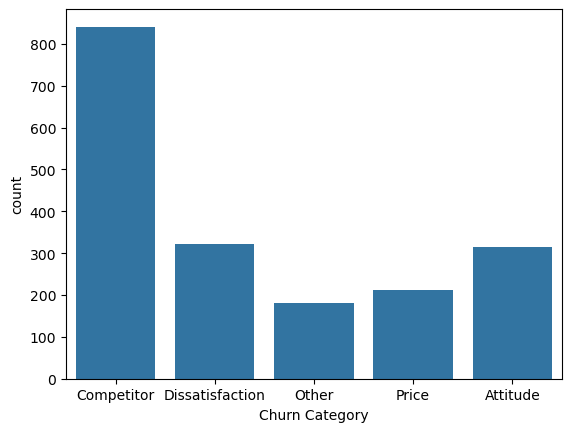

In [60]:
sns.countplot(df_valuable_customer, x="Churn Category")

<Axes: xlabel='Churn Reason', ylabel='count'>

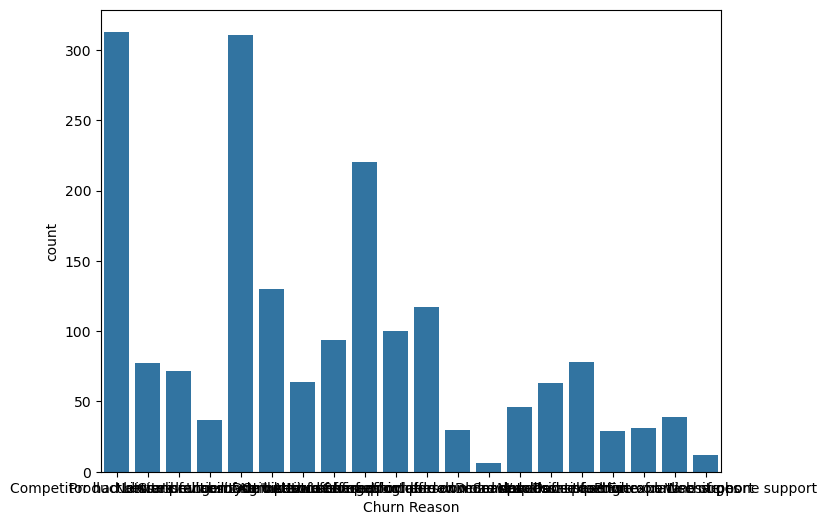

In [66]:
plt.figure(figsize=(8, 6))
sns.countplot(df_valuable_customer, x="Churn Reason")

In [56]:
df_valuable_customer[["Tenure in Months", "Total Revenue", "Age", "Number of Referrals"]].corr()

,Tenure in Months,Total Revenue,Age,Number of Referrals
Tenure in Months,1.000000,0.853146,0.009927,0.326975
Total Revenue,0.853146,1.000000,0.048265,0.261853
Age,0.009927,0.048265,1.000000,-0.025141
Number of Referrals,0.326975,0.261853,-0.025141,1.000000


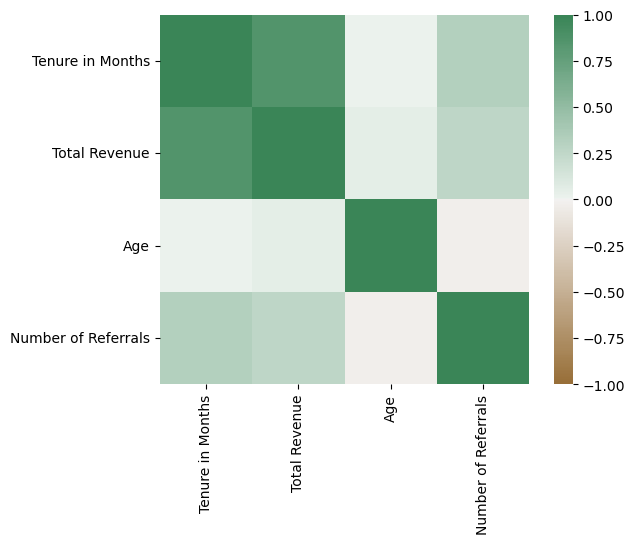

In [57]:
correlation_valuable_customer = df_valuable_customer[["Tenure in Months", "Total Revenue", "Age", "Number of Referrals"]].corr()

axis_corr = sns.heatmap(
correlation_valuable_customer,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(50, 500, n=500),
square=True
)

plt.show() 

### Task 6

Do an exploratory analysis of the feature variable decided upon in Task 4.

In [92]:
tenure_customer_joined = df_valuable_customer[df_valuable_customer["Customer Status"] == "Joined"]["Tenure in Months"]

In [94]:
tenure_customer_joined

17      1
23      3
48      1
88      2
100     3
       ..
6938    1
6973    1
7021    1
7033    1
7040    2
Name: Tenure in Months, Length: 454, dtype: int64

### Task 7

Deal with missing values among the chosen feature variables.

In [ ]:
df_valuable_customer = df_valuable_customer.fillna({"Multiples Lines": "No"})

In [75]:
df_valuable_customer.isna().sum()

Tenure in Months          0
Age                       0
Total Revenue             0
Number of Referrals       0
Customer Status           0
Churn Category         5174
Churn Reason           5174
dtype: int64

In [ ]:
df_valuable_customer = df_valuable_customer[df_valuable_customer["Tenure in Months"] > 3] # what is this for?

In [82]:
df_valuable_customer

,Tenure in Months,Age,Total Revenue,Number of Referrals,Customer Status,Churn Category,Churn Reason
0,9,37,974.81,2,Stayed,NaN,NaN
1,9,46,610.28,0,Stayed,NaN,NaN
2,4,50,415.45,0,Churned,Competitor,Competitor had better devices
3,13,78,1599.51,1,Churned,Dissatisfaction,Product dissatisfaction
4,3,75,289.54,3,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...
7038,13,20,1349.74,0,Stayed,NaN,NaN
7039,22,40,2230.10,1,Churned,Dissatisfaction,Product dissatisfaction
7040,2,22,129.99,0,Joined,NaN,NaN
7041,67,21,4769.69,5,Stayed,NaN,NaN


### Task 8

Do relevant data transformation to the target variable.

In [99]:
# scaling

In [101]:
scale = StandardScaler()

X = scale.fit_transform(X)

In [102]:
X

array([[-0.95299362, -0.56777322, -0.71887199,  0.01603903],
       [-0.95299362, -0.03043292, -0.84610754, -0.65040855],
       [-1.15673995,  0.20838499, -0.914111  , -0.65040855],
       ...,
       [-1.23823849, -1.46334039, -1.01374796, -0.65040855],
       [ 1.41046388, -1.52304487,  0.60569294,  1.01571039],
       [ 1.24746681, -0.6274777 ,  0.23498104, -0.31718476]])

### Task 9

Turn all the categorical variables into dummy variables.

In [ ]:
#CatVar = df_valuable_customer[""] # I dont have any
#X = pd.get_dummies(data = X, columns=CatVar, drop_first=True, dtype="int")

### Task 10 

Create the final X feature set and the final y target variable. Make sure that 1 means Churned and 0 means Stayed. Also create a train-test split of dataset (leaving 20% for test).

In [125]:
df_valuable_customer2 = df_valuable_customer[df_valuable_customer["Customer Status"] != "Joined"]
df_valuable_customer2

,Tenure in Months,Age,Total Revenue,Number of Referrals,Customer Status,Churn Category,Churn Reason
0,9,37,974.81,2,Stayed,NaN,NaN
1,9,46,610.28,0,Stayed,NaN,NaN
2,4,50,415.45,0,Churned,Competitor,Competitor had better devices
3,13,78,1599.51,1,Churned,Dissatisfaction,Product dissatisfaction
4,3,75,289.54,3,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...
7037,4,36,93.54,0,Churned,Competitor,Competitor made better offer
7038,13,20,1349.74,0,Stayed,NaN,NaN
7039,22,40,2230.10,1,Churned,Dissatisfaction,Product dissatisfaction
7041,67,21,4769.69,5,Stayed,NaN,NaN


In [126]:
X = df_valuable_customer2[["Tenure in Months", "Age", "Total Revenue", "Number of Referrals"]]

In [127]:
y = df_valuable_customer2["Customer Status"]

In [121]:
y = y.reset_index()

In [123]:
y = y[y["Customer Status"] != "Joined"] # do this beofre splitting to x and y
y

,index,Customer Status
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
7037,7037,1
7038,7038,0
7039,7039,1
7041,7041,0


In [116]:
y = y.drop(y["Joined"])

le_drop = y[(y['Customer Status'] == 'Joined')].index
df.drop(indexAge, inplace=True)

KeyError: 'Joined'

In [128]:
y = y.replace({"Stayed": 0, "Churned": 1})
y

C:\Users\Bruger\AppData\Local\Temp\ipykernel_13448\4067525327.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"Stayed": 0, "Churned": 1})


0       0
1       0
2       1
3       1
4       1
       ..
7037    1
7038    0
7039    1
7041    0
7042    0
Name: Customer Status, Length: 6589, dtype: int64

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75432)

### Task 11

Decide on how to evaluate the churn prediction model. That is, decide what machine learning performance measure(s) to evaluate your model on, but also think about whether you want to calculate additional things to evaluate the models from a business perspective.

In [80]:
y.value_counts()

# 7043 - 454  = 6.589  stayed = 71.63%

Customer Status
0         4720
1         1869
Joined     454
Name: count, dtype: int64

<Axes: xlabel='Customer Status', ylabel='count'>

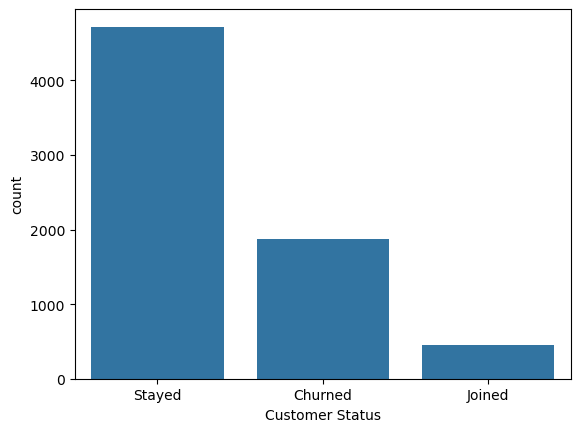

In [78]:
sns.countplot(df_valuable_customer, x="Customer Status")

    Given the scewed data set, an score belov 73% accuracy is below random guessing, it should be possible to have an score above 90%
    The challenge itself wants to identify high value customers and churn risk, it wants to accurately predict churn and what causes it and what features reflects a high value customer

    f1, find false negative, precision
    Using classification

### Task 12

Train a quick baseline model to predict churn, that can be used for comparison for all future models. For this, use a multiple logistic regression. Use cross-validation to get an unbiased estimate of the model's accuracy on new unseen data. Finally, plot the model's confusion matrix.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75432)

In [108]:
y_train

2461         0
3291         0
4606         1
2294         0
6169         0
         ...  
3788         0
6537         0
4315         1
1109    Joined
2206         0
Name: Customer Status, Length: 5634, dtype: object

In [104]:
logit_model_sk = linear_model.LogisticRegression()

In [105]:
logit_model_sk.fit(X_train, y_train)

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

### Task 13

The code below creates under-sampled versions of the training data (`_us`) and over-sampled versions of the training data (`_os`). Use these two new pair of training data to retrain logic regression models. It assumes that you have created a train-test split such that the training target variable is called `y_train` and that it takes values 0 and 1, where 1 means "Churned".

In [ ]:
from sklearn.utils import resample

minority_class_index = y_train[y_train == 1].index
majority_class_index = y_train[y_train == 0].index

In [ ]:
# Under-sampling the majority class
under_sample_index = resample(majority_class_index, replace=False, n_samples=len(minority_class_index), random_state=42)
under_sample_indexes = under_sample_index.union(minority_class_index)

In [ ]:
X_train_us = X_train.loc[under_sample_indexes, :]
y_train_us = y_train[under_sample_indexes]
print("X_train_us shape:", X_train_us.shape)
print("y_train_us shape:", y_train_us.shape)

In [ ]:
# Over-sampling the minority class
over_sample_index = resample(minority_class_index, replace=True, n_samples=len(majority_class_index), random_state=42)
over_sample_indexes = over_sample_index.union(majority_class_index)

In [ ]:
X_train_os = X_train.loc[over_sample_indexes, :]
y_train_os = y_train[over_sample_indexes]
print("X_train_os shape:", X_train_os.shape)
print("y_train_os shape:", y_train_os.shape)

### Task 14

Train a K-Nearest Neighbor classifier for the over-sampled data. Remember to use cross-validation to get a good estimate of what K to chose.

### Task 15

Evaluate the logistic regression and K-Nearest Neighbor on all the relevant metrics (as discussed in Task 11), including at least one business metric.

### Example of hyper-parameter tuning with cross validation

In this example, we will train a Random Forest model and do some grid search together with cross-validation, to find an optimal model. Note that, the parameter grid is just chosen to make an example, it is not guaranteed to be the best grid of parameters for this model.

In [ ]:
param_grid = [
  {"n_estimators": [400, 600, 800],
   "max_depth":  [4, 8, 12],
   "min_samples_leaf": [5, 10]}
 ]

In [ ]:
rf_model = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv = 5, scoring = "accuracy")

In [ ]:
gs_out = grid_search.fit(X_train_os, y_train_os)
gs_out

In [ ]:
gs_out.best_estimator_

In [ ]:
gs_out.best_score_

In [ ]:
gs_out.best_params_

### Task 16

Now, train various tree-based models such as decision trees, Random Forest, AdaBoost, and XGBoost. Remember to use Cross-validation and hyper-parameter tuning, to get the best models.